In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
df = pd.read_csv('NVDA.csv', parse_dates=['Date'], index_col='Date')

# Display the first few rows
print(df.head())

# Feature engineering: use historical prices to predict future prices
df['Target'] = df['Close'].shift(-1)  # Predict the next day's closing price

# Drop rows with NaN values (from shifting)
df.dropna(inplace=True)

# Select features and target
features = df[['Close']].values
target = df['Target'].values

# Scale features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Create sequences for LSTM input
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

# Parameters
SEQ_LENGTH = 10

X, y = create_sequences(features_scaled, target, SEQ_LENGTH)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2023-08-29  46.666000  49.081001  46.390999  48.784000  48.769402  701397000
2023-08-30  49.043999  49.926998  48.424999  49.264000  49.249252  735206000
2023-08-31  49.380001  49.743999  48.958000  49.355000  49.340225  528570000
2023-09-01  49.762001  49.799999  48.141998  48.508999  48.494484  463830000
2023-09-05  48.223000  48.851002  47.860001  48.548000  48.533470  382653000


In [3]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
6/6 [==============================] - 3s 113ms/step - loss: 4482.3774 - val_loss: 14163.2480
Epoch 2/10
6/6 [==============================] - 0s 9ms/step - loss: 4460.3325 - val_loss: 14057.0654
Epoch 3/10
6/6 [==============================] - 0s 9ms/step - loss: 4412.8784 - val_loss: 13797.6387
Epoch 4/10
6/6 [==============================] - 0s 9ms/step - loss: 4291.0869 - val_loss: 13295.3574
Epoch 5/10
6/6 [==============================] - 0s 9ms/step - loss: 4028.5698 - val_loss: 12864.6611
Epoch 6/10
6/6 [==============================] - 0s 9ms/step - loss: 3764.3989 - val_loss: 12561.9512
Epoch 7/10
6/6 [==============================] - 0s 9ms/step - loss: 3593.2153 - val_loss: 12353.5000
Epoch 8/10
6/6 [==============================] - 0s 9ms/step - loss: 3485.4927 - val_loss: 12209.1982
Epoch 9/10
6/6 [==============================] - 0s 9ms/step - loss: 3415.9351 - val_loss: 12097.9180
Epoch 10/10
6/6 [==============================] - 0s 9ms/step - loss: 

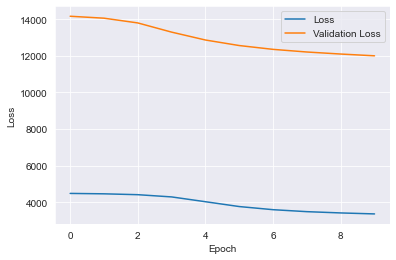

In [4]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Plot training history
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


2/2 [==============================] - 0s 4ms/step - loss: 12254.2578
Test Loss: 12254.2578125
2/2 [==============================] - 1s 4ms/step


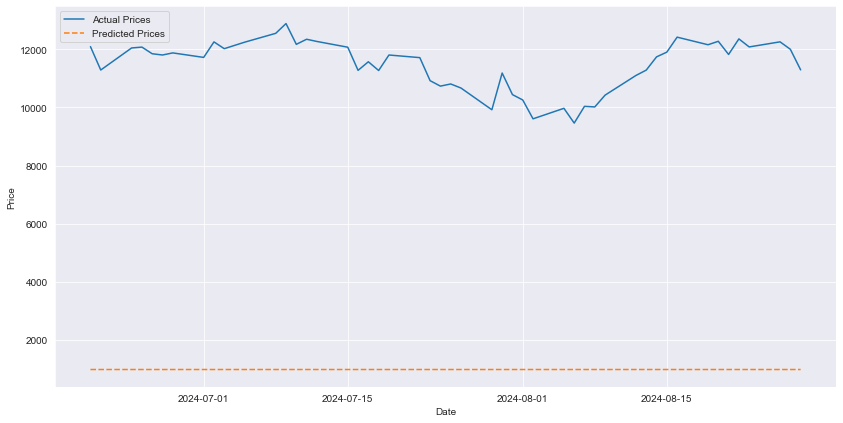

In [5]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values for comparison
predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test):], y_test_inv, label='Actual Prices')
plt.plot(df.index[-len(predictions):], predictions_inv, label='Predicted Prices', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
